In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import random
import itertools

In [2]:

##################################################################
#######                Data Preperation                    #######
##################################################################

df = pd.read_csv("C:\\Users\\ASMGX\\Desktop\\lixar\\echocardiogram_train.csv")

#Replace ? values with null
df = df.replace("?", np.nan)

#Remove not needed attributes
df.drop(["wall-motion-score", "name", "group"], axis=1, inplace=True)

df= df.apply(pd.to_numeric)


#Fill missing age-at-heart-attack with average value
df["age-at-heart-attack"].fillna(df["age-at-heart-attack"].mean(), inplace=True)

#Fill missing fractional-shortening with average value
df["fractional-shortening"].fillna(df["fractional-shortening"].mean(), inplace=True)

#Fill missing epss with average value
df["epss"].fillna(df["epss"].mean(), inplace=True)

#Fill missing lvdd with average value
df["lvdd"].fillna(df["lvdd"].mean(), inplace=True)

#Fill missing wall-motion-index with average value
df["wall-motion-index"].fillna(df["wall-motion-index"].mean(), inplace=True)

#Fill missing wall-motion-index with average value
df["mult"].fillna(df["mult"].mean(), inplace=True)


#Fill new_alive-at-1 with its value based on still-alive and survival
df["alive-at-1"] = np.where( df["alive-at-1"].notnull(), df["alive-at-1"],
                       np.where( (df["still-alive"] == 1)  & (df["survival"] < 12), 1, 0 ))

#as requested "patients cannot be used for the prediction task mentioned above."
df = df[df["alive-at-1"] == 0]


#If pts survival >= 24 then pts Survived-2yrs (1) , regarless still alive or not
#If pts is dead and survival < 24 then pts Did-Not-Survive-2yrs (0)
#If pts is still alive and survival < 24 then pt is undetairmend NULL, 
#it could be they die before reach the 24 months mark, or stay alive till reaching 24
#therefore these reocrds (still-alive=1 & survival<24) will be excluded
#This step can replace the step above where alive-at-1 missing values get filled
#and excluded 

df["survived-2"] = np.where( (df["survival"] >= 24), 1, 
                   np.where( (df["still-alive"] == 0), 0, np.nan))

df = df[df["survived-2"].notnull()]

   survival  still-alive  age-at-heart-attack  pericardial-effusion  \
0      11.0            0                 71.0                     0   
1      19.0            0                 72.0                     0   
2      16.0            0                 55.0                     0   
3      57.0            0                 60.0                     0   
5      26.0            0                 68.0                     0   

   fractional-shortening    epss   lvdd  wall-motion-index   mult  alive-at-1  \
0                  0.260   9.000  4.600               1.00  1.000         0.0   
1                  0.380   6.000  4.100               1.70  0.588         0.0   
2                  0.260   4.000  3.420               1.00  1.000         0.0   
3                  0.253  12.062  4.603               1.45  0.788         0.0   
5                  0.260   5.000  4.310               1.00  0.857         0.0   

   survived-2  
0         0.0  
1         0.0  
2         0.0  
3         1.0  
5     

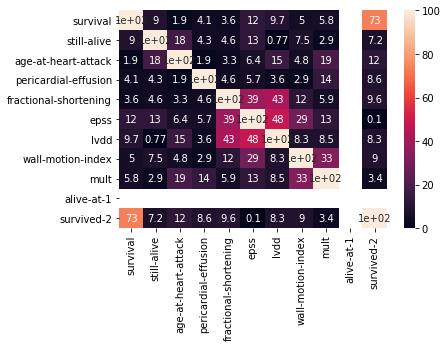

In [5]:
print(df.head())
print(df.describe())

corr = np.abs(100 * df.corr())

sns.heatmap(corr, annot=True)

In [9]:
##################################################################
#######      Feature Selection & Prediction                #######
#######        & Hyper-Param Optimization                  #######
##################################################################


C = df.drop(["survival", "still-alive", "mult", "alive-at-1", "survived-2"], axis=1).columns
y = df["survival"]

best_Accuracy = 0
best_k = 0

for i in range(1,5):
    #Hyper-Parm Selection [Random]
    k = random.randint(10,500)
    mdl = RandomForestRegressor(n_estimators = k) #76
    #mdl = LinearRegression() #73
    #mdl = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    
    for L in range(1, len(C)+1):
        for subset in itertools.combinations(C, L):
            X = df[list(subset)]


            #print("Test k = ",k)
            #print("Test subset = ",subset)
            
            #5-Folder Cross Validation
            y_pred = cross_val_predict(mdl, X, y, cv=5)
            
            Accuracy = 100 * (1 - np.abs(np.where(y_pred >=24,1,0) - df["survived-2"]).mean())
            
            #print("Test Accuracy = ",Accuracy)
            if Accuracy > best_Accuracy :
                best_k = k
                best_subset = subset
                best_Accuracy = Accuracy
                print("*********************************")
                print("So far, Best k ==>",k)
                print("So far, Best subset ==>",subset)
                print("So far, Best Accuracy ==>",Accuracy)
                print("*********************************")


print("*********************************")
print("*********************************")
print("*** Best k =", best_k)
print("*** Best Features =", best_subset)
print("*** Accuracy =", best_Accuracy)
print("*********************************")
print("*********************************")

*********************************
So far, Best k ==> 405
So far, Best subset ==> ('age-at-heart-attack', 'pericardial-effusion')
So far, Best Accuracy ==> 57.74647887323944
*********************************
*********************************
So far, Best k ==> 405
So far, Best subset ==> ('age-at-heart-attack', 'fractional-shortening')
So far, Best Accuracy ==> 66.19718309859155
*********************************
*********************************
So far, Best k ==> 405
So far, Best subset ==> ('age-at-heart-attack', 'epss')
So far, Best Accuracy ==> 67.6056338028169
*********************************
*********************************
So far, Best k ==> 405
So far, Best subset ==> ('fractional-shortening', 'epss')
So far, Best Accuracy ==> 71.83098591549295
*********************************
*********************************
So far, Best k ==> 405
So far, Best subset ==> ('age-at-heart-attack', 'fractional-shortening', 'epss')
So far, Best Accuracy ==> 76.05633802816901
********************

In [41]:

##################################################################
#######      Predict unlabelled dataset                    #######
##################################################################




dfTest = pd.read_csv("C:\\Users\\ASMGX\\Desktop\\lixar\\echocardiogram_test.csv")

#Replace ? values with null
dfTest = dfTest.replace("?", np.nan)


#Remove not needed attributes
dfTest.drop(["survival", "still-alive", "wall-motion-score", "mult", "name", "group", "alive-at-1"], axis=1, inplace=True)

dfTest= dfTest.apply(pd.to_numeric)


#Fill missing age-at-heart-attack with average value
dfTest["age-at-heart-attack"].fillna(dfTest["age-at-heart-attack"].mean(), inplace=True)

#Fill missing fractional-shortening with average value
dfTest["fractional-shortening"].fillna(dfTest["fractional-shortening"].mean(), inplace=True)

#Fill missing epss with average value
dfTest["epss"].fillna(dfTest["epss"].mean(), inplace=True)

#Fill missing lvdd with average value
dfTest["lvdd"].fillna(dfTest["lvdd"].mean(), inplace=True)

#Fill missing wall-motion-index with average value
dfTest["wall-motion-index"].fillna(dfTest["wall-motion-index"].mean(), inplace=True)



X = df[list(best_subset)]
XTest = dfTest[list(best_subset)]
y = df["survival"]


mdl = RandomForestRegressor(n_estimators = best_k)
mdl.fit(X,y)

y_predTest = mdl.predict(XTest)
y_predTest = pd.DataFrame(y_predTest)

pd.options.mode.chained_assignment = None 

XTest["predicted_survival"] = y_predTest

XTest["predicted_survived-2"] = np.where(y_predTest >=24,1,0)

XTest.to_csv("C:\\Users\\ASMGX\\Desktop\\lixar\\Regression_Test.csv")

print(XTest)

    age-at-heart-attack  pericardial-effusion  fractional-shortening  epss  \
0             61.000000                     0                   0.27   9.0   
1             59.000000                     1                   0.40   9.2   
2             57.000000                     0                   0.29   9.4   
3             62.000000                     1                   0.19  28.9   
4             60.176471                     0                   0.26   0.0   
5             54.000000                     0                   0.43   9.3   
6             62.000000                     1                   0.24  28.6   
7             60.176471                     0                   0.23  19.1   
8             64.000000                     0                   0.15   6.6   
9             57.000000                     1                   0.12   0.0   
10            61.000000                     0                   0.18   0.0   
11            61.000000                     1                   